In [2]:
 #load Raw data from TDT ECoG maschine, plz run ""
import numpy as np
import scipy.io as scio
from scipy import signal
import tdt
import os
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft
from random import shuffle
import h5py
import scipy.io as scio
import math
import mne
import torch   
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [ ]:
freq = 500
HS = 69
elec = 74

PATH='/public/DATA/overt_reading/'

PATH='/public/DATA/overt_reading/points'
cue_points=np.load(os.path.join(PATH,f'HS{HS}_oneset_cue_point.npy'),allow_pickle=True)
read_point=np.load(os.path.join(PATH,f'HS{HS}_onset_read_time.npy'),allow_pickle=True)
delay=np.load(os.path.join(PATH,f'HS{HS}_delay_list.npy'),allow_pickle=True)

cue_points # block 0: [142730, 147229, 151729] 间隔为2000+2500=4500
read_point # block 0: [144729, 149229, 153729] = cue onset + 2000 间隔为2500+2000=4500

In [ ]:
ecog_data_path = f'/public/DATA/overt_reading/processed_data/HS{HS}/{freq}/'
num_block = len(os.listdir(ecog_data_path))
print(f'blcok counts: {num_block}')

for block in os.listdir(ecog_data_path):
    ecog_data = np.load(os.path.join(ecog_data_path, block))
    plt.figure(figsize=(12, 6))
    plt.plot(ecog_data[elec, 142730:142730+2000], label='Cue', color='blue')
    plt.plot(ecog_data[elec, 144729:144729+2500], label='Read', color='red')
    plt.tight_layout()
    plt.show()


In [9]:
channel_num = 256
num_channels = 256
ecog_freq = 100
forward = int(1 * 400)
backward = int(4.5 * 400)
forward_sound = int(1 * 3052)
backward_sound = int(4.5 * 3052)
step = int(4)
length = (forward + backward) // step
time_duration = length / 100
print(length)


def nansem(a, axis=1):
    return np.nanstd(a, axis=1) / np.sqrt(a.shape[axis])

def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None, alpha=0.6):
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.nanmean(a, axis=1)
    sem = nansem(a, axis=1)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, color=color)
    else:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, )

    if ylim is not None:
        ax.set(ylim=ylim)
        ax.set(xlim=(xvals[0], xvals[-1]))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    return h


def plot_filled_sem_2(a, xvals, ax=None, color=None, ylim=None, alpha=0.6): # 仅保留均值线
    if ax is None:
        fig, ax = plt.subplots()
        mean = np.nanmean(a, axis=1)
        sem = nansem(a, axis=1)
        ax.axvline(0, color='gray', linewidth=0.5)
        ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean, mean, alpha=alpha, color=color)
    else:
        h = ax.fill_between(xvals, mean, mean, alpha=alpha, )

    if ylim is not None:
        ax.set(ylim=ylim)
        ax.set(xlim=(xvals[0], xvals[-1]))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    return ax


550


In [ ]:
def ERP_HS_elec_figure_region(HS,elec, check_list, color_list, listen=False,ylim=[-0.5,1],cue=False):

    #xvals = np.linspace(-0.5, 0.6, 110)
    xvals = np.linspace(-1, 4.5, int(ecog_freq * time_duration)) # 100为采样频率
    if listen:
        xvals = np.linspace(0, 2, int(ecog_freq * 2)) # 100为采样频率
    if cue == True:
        xvals = np.linspace(0, 1, int(ecog_freq * 1)) # 100为采样频率
    fig,ax=plt.subplots(figsize=(10,5))

    h_list = [ ]
    for k in range(len(check_list)):
        a = HS_BLOCK[f"HS{HS}"][check_list[k]][int(elec)]
        if cue == True:
            h = plot_filled_sem(a[100:200], xvals, ax=ax, color=color_list[k], alpha=0.7)
        else:
            h = plot_filled_sem(a, xvals, ax=ax, color=color_list[k], alpha=0.7)
        h_list.append(h)

    ax.set_ylim(ylim)
    #ax.text(0.1, 0.85, f"{HS}_{elec}", transform=ax.transAxes)
    ax.set_title(f"{HS}_{elec}")
    ax.legend(h_list,check_list,loc='upper right')
    if not listen:
        ax.axvline(2, color='gray', linewidth=0.5)
    #ax.axvline(, color='gray', linewidth=0.5)
        if cue==True:
            ax.set(yticklabels=[], xticklabels=[], xticks=[0, 0.3, 0.5])
        else:
            ax.set(yticklabels=[], xticklabels=[], xticks=[0, 2, 3.5])
        # ax.axvline(3.5, color='gray', linewidth=0.5)
        # ax.text(-0.4, 3.5, f"文字出现" )
        # ax.text(1.5, 3.5, f"红灯变绿灯")
        # ax.text(3.1, 3.5, f"文字消失")
    else:
        ax.axvline(1, color='gray', linewidth=0.5)
        ax.set(yticklabels=[], xticklabels=[], xticks=[0, 1])

In [3]:
subjects = [69,75,82,83,84,85,86]
from overt_reading_process import HS_block_erps

# subjects = [69]
path = '/public/DATA/overt_reading/'

sig_elecs_HS_lists = {}
for HS in subjects:
    freq = 500
    subject = f"HS{HS}"
    sig_elecs_HS_lists[subject] =np.load(os.path.join(path, f'blocked_data/HS{HS}block.npy'),allow_pickle=True).item()
    
HS_BLOCK = {}
for subject in subjects:
    HS_DATA = HS_block_erps.HS_block_process(subject,path)
    HS_BLOCK[f"HS{subject}"] = HS_DATA.get_HSblock()

HS = 69
HS69block_data = np.load(os.path.join(path, f'blocked_data/HS{HS}block.npy'), allow_pickle=True).item()
HS69block_data['功课'].shape #256 x time x trail (256, 550, 36)

550


(256, 550, 34)

In [9]:
def nansem(a, axis=1):
    return np.nanstd(a, axis=1) / np.sqrt(a.shape[axis])


def get_word_used(task,word):
    if task == "listen":
        if word in ['数页','shù yè']:
            word = "树叶"
        if word in ['宫客','gōng kè']:
            word = "功课"

        word_used = word + " listen"
    else:
        word_used = word
    return word_used
def get_ecog_used(task,ecog,noise_ceiling = False,mean = True,window=[0,200]):
    """
    返回shape[times,n_trials]
    """

    DuringTime = {"listen_time": [0, 200],
     "cue_time": [100, 300],
     "reading_time": [300, 500]}
    if mean == True:
        if noise_ceiling:
            a,b= np.mean(ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],:ecog.shape[1]//2],axis = 1), np.mean(ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],ecog.shape[1]//2:],axis = 1)
            return a[window[0]:window[1]],b[window[0]:window[1]]
        else: 
            a=  np.mean(ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],:],axis = 1)
            return a[window[0]:window[1]]
    else:
        if noise_ceiling:
            a,b = ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],:ecog.shape[1]//2], ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],ecog.shape[1]//2:]
            return a[window[0]:window[1],:],b[window[0]:window[1],:]
        else: 
            a =   ecog[DuringTime[f"{task}_time"][0]:DuringTime[f"{task}_time"][1],:]
            return a[window[0]:window[1],:]
    
def plot_heatmap(HS,elec,plot=True,ax=None,ytick=True):
   
    a = []
    b = []
    keys = ['功课','树叶', '力果','对十', '宫客','数页', '作业','绿草', 'gōng kè','shù yè']
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    
    for task in ['cue','reading','listen']:
        for word in keys:
            if task=='listen' and word in [ '宫客', 'gōng kè','数页','shù yè']:
                pass
            else: 
                a.append(get_ecog_used(task,HS_BLOCK[f"HS{HS}"][get_word_used(task,word)][int(elec)]))
                b.append(f'{task}_{word}')
    if plot == True:
        if ytick==False:
            b=[]
        if ax ==None:
            plt.figure()
            sns.heatmap(a,cmap='RdBu_r',yticklabels=b,xticklabels=[])
        else:
            sns.heatmap(a,cmap='RdBu_r',yticklabels=b,xticklabels=[],ax=ax)
    else:
        return np.array(a),b
channel_num = 256
num_channels = 256
ecog_freq = 100
forward = int(1 * 400)
backward = int(4.5 * 400)
forward_sound = int(1 * 3052)
backward_sound = int(4.5 * 3052)
step = int(4)
length = (forward + backward) // step
time_duration = length / 100
print(length)


def nansem(a, axis=1):
    return np.nanstd(a, axis=1) / np.sqrt(a.shape[axis])

def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None, alpha=0.6):
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.nanmean(a, axis=1)
    sem = nansem(a, axis=1)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, color=color)
    else:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, )

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return h

def plot_filled_sem_2(a, xvals, ax=None, color=None, ylim=None, alpha=0.6):  # 仅保留均值线
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.nanmean(a, axis=1)
    sem = nansem(a, axis=1)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean, mean, alpha=alpha, color=color)
    else:
        h = ax.fill_between(xvals, mean, mean, alpha=alpha, )

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax


color_set = {'superiorfrontal': 'grey',
             'superiortemporal': 'purple',
             'inferiorparietal': 'skyblue',
             'rostralmiddlefrontal': 'black',
             'parstriangularis': 'darkgreen',
             'superiorparietal': 'orange',
             'postcentral': 'red',
             'parsopercularis': 'gold',
             'middletemporal': 'greenyellow',
             'inferiortemporal': 'pink',
             'parsorbitalis': 'olive',
             'supramarginal': 'green',
             'lateraloccipital': 'navy',
             'bankssts': 'rosybrown',
             'precentral': 'blue',
             'caudalmiddlefrontal': 'slategrey'}
def ERP_HS_elec_figure_region(HS,elec, check_list, color_list, listen=False,ylim=[-0.5,1],cue=False):

    #xvals = np.linspace(-0.5, 0.6, 110)
    xvals = np.linspace(-1, 4.5, int(ecog_freq * time_duration))  # 100为采样频率
    if listen:
        xvals = np.linspace(0, 2, int(ecog_freq * 2))  # 100为采样频率
    if cue == True:
        xvals = np.linspace(0, 1, int(ecog_freq * 1))  # 100为采样频率
    fig,ax=plt.subplots(figsize=(10,5))

    h_list = [ ]
    for k in range(len(check_list)):
        a = HS_BLOCK[f"HS{HS}"][check_list[k]][int(elec)]
        if cue == True:
            h = plot_filled_sem(a[100:200], xvals, ax=ax, color=color_list[k], alpha=0.7)
        else:
            h = plot_filled_sem(a, xvals, ax=ax, color=color_list[k], alpha=0.7)
        h_list.append(h)

    
    ax.set_ylim(ylim)
    #ax.text(0.1, 0.85, f"{HS}_{elec}", transform=ax.transAxes)
    ax.set_title(f"{HS}_{elec}")
    ax.legend(h_list,check_list,loc='upper right')
    if not listen:
        ax.axvline(2, color='gray', linewidth=0.5)
        #ax.axvline(, color='gray', linewidth=0.5)
        if cue==True:
           ax.set(yticklabels=[], xticklabels=[], xticks=[0, 0.3, 0.5])
        else:
            ax.set(yticklabels=[], xticklabels=[], xticks=[0, 2, 3.5])
        # ax.axvline(3.5, color='gray', linewidth=0.5)
        # ax.text(-0.4, 3.5, f"文字出现" )
        # ax.text(1.5, 3.5, f"红灯变绿灯")
        # ax.text(3.1, 3.5, f"文字消失")
    else:
        ax.axvline(1, color='gray', linewidth=0.5)
        ax.set(yticklabels=[], xticklabels=[], xticks=[0, 1])

550


NameError: name 'plot_filled_sem' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

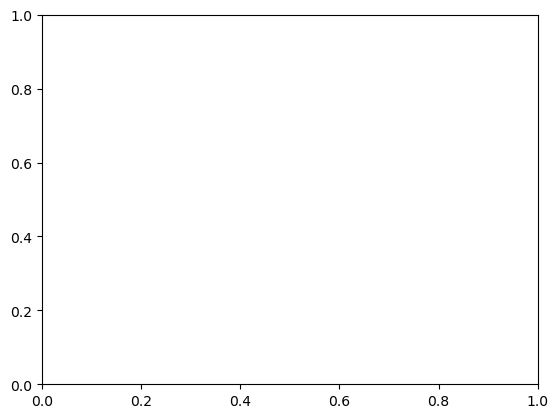

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

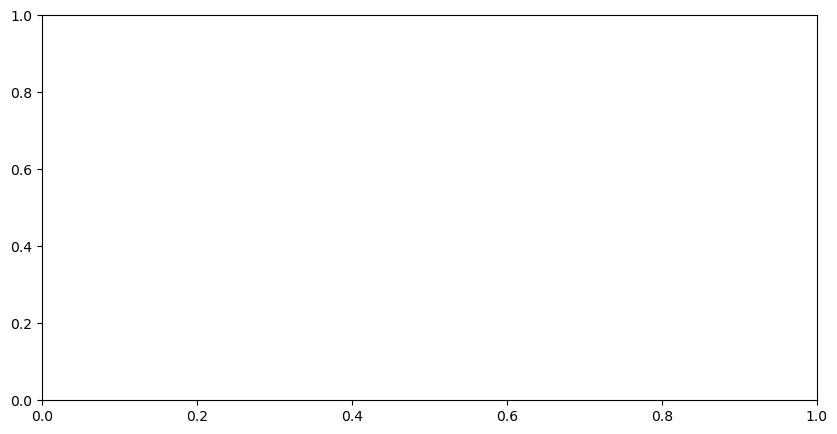

In [8]:
HS = 69
elec = 74
# rdm = RDM_matrix[f"{HS}_{elec}"]
fig,ax = plt.subplots()

check_list_2 = ['树叶','数页','shù yè','对十','绿草']
check_list_1 = ['功课','宫客','gōng kè','力果','作业']
color_list = [(32/255,48/255,69/255),(125/255,144/255,184/255),(166/255,185/255,215/255),(174/255,88/255,69/255),(216/255,174/255,160/255)]

ERP_HS_elec_figure_region(HS,elec,check_list_1,color_list,cue=True)
ERP_HS_elec_figure_region(HS,elec,check_list_2,color_list,cue=True)

check_list_listen_1 = ['树叶 listen','对十 listen','绿草 listen']
check_list_listen_2 = ["功课 listen",'力果 listen','作业 listen']
color_list_listen = [(32/255,48/255,69/255),(174/255,88/255,69/255),(216/255,174/255,160/255),'y']
ERP_HS_elec_figure_region(HS,elec,check_list_listen_2,color_list_listen,listen=True)
ERP_HS_elec_figure_region(HS,elec,check_list_listen_1,color_list_listen,listen=True)